# Assignment 14: Assessing the significance of results
#### 15th December 2020

In [1]:
# edapy_12_00 clear all variables and import vatious modules
# History
# 2022/06/26 -  checked with most recent Python & etc. software
%reset -f
import os
from datetime import date
from math import exp, pi, sin, cos, tan, sqrt, floor, ceil, log, atan2
import numpy as np
import scipy.sparse.linalg as las
import scipy.interpolate as ip
import scipy.spatial as sp
from scipy import sparse
import scipy.linalg as la
import scipy.signal as sg
import scipy.stats as stats
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

# function to make a numpy N-by-1 column vector
# c=eda_cvec1(v) from entity v that is array-like,
# including a number, a list of numbers, a tuple
# of numbers, an N-by-0 np array and a N-by1 np array.
# It promotes integers to floats, and integers
# and floats to complex, by context. The function
# also insures that, if v is an np array, that
# c is a copy, as contrasted to a view, of it.
# This version takes just one input argment.
# whereas c=eda_cvec(v1,v2,...) concatenates
# many argiments.
def eda_cvec1(v):
    if isinstance(v, int):
        w = np.zeros((1,1),dtype=int);
        w[0,0] = v;
        return w;
    elif isinstance(v, float):
        w = np.zeros((1,1),dtype=float);
        w[0,0] = v;
        return w;
    elif isinstance(v, complex):
        w = np.zeros((1,1),dtype=complex);
        w[0,0] = v;
        return w;
    elif isinstance(v, np.ndarray):
        s = np.shape(v);
        if len(s) == 1:
            return np.copy(np.reshape(v,(s[0],1)));
        else:
            [r,c]=s;
            if( c==1 ):
                return(np.copy(v));
            elif(r==1):
                return(np.copy(v.T));
            else:
                raise TypeError("eda_cvec: %d by %d ndarray not allowed" % (r, c));
    elif isinstance(v, list):
        r = len(v);
        t = int;
        for vi in v:
            if isinstance(vi,int):
                pass;
            elif isinstance(vi,float):
                t=float;
            elif isinstance(vi,complex):
                t=complex;
                break;
            else:
                raise TypeError("eda_cvec: list contains unsupported type %s" % type(vi));
        w = np.zeros((r,1),dtype=t);
        w[:,0] = v;
        return w;
    elif isinstance(v, tuple):
        r = len(v);
        t = int;
        for vi in v:
            if isinstance(vi,int):
                pass;
            elif isinstance(vi,float):
                t=float;
            elif isinstance(vi,complex):
                t=complex;
                break;
            else:
                raise TypeError("eda_cvec: tuple contains unsupported type %s" % type(vi));
        w = np.zeros((r,1),dtype=t);
        w[:,0] = v;
        return w;
    else:
        raise TypeError("eda_cvec: %s not supported" % type(v));
        
# function to make a numpy N-by-1 column vector
# c=eda_cvec(v1, v2, ...) from a list of several
# array-like entities v1, v2, including a number
# a list of numbers, a tuple of numbers, an N-by-0 np array
# and a N-by-1 np array. The function
# also insures that, if v is an np array, that
# c is a copy, as contrasted to a view, of it
# It promotes integers to floats, and integers
# and floats to complex, by context.
# This version concatenates many argments,
# whereas c=eda_cvec1(v1) takes just one argiment.
# I recommend always using eda_cvec(v1, v2, ...)
def eda_cvec(*argv):
    t = int;
    Nt = 0;
    for a in argv:
        v = eda_cvec1(a);
        N,M = np.shape(v);
        Nt = Nt + N;
        if( N==0 ):
            continue; # skip vector of zero length
        if (t==int) and isinstance(v[0,0],float):
            t=float;
        elif isinstance(v[0,0],complex):
            t=complex;
    w = np.zeros((Nt,1),dtype=t);
    Nt = 0;
    for a in argv:
        v = eda_cvec1(a);
        N,M = np.shape(v);
        w[Nt:Nt+N,0] = v[0:N,0];
        Nt = Nt + N;
    return w;

# eda_draw function makes a "pictorial matrix equation"
# arguments are vectors, matrices and strings
# which are plotted in the order that the appear
# except that strings starting with 'title ' are plotted
# under the subseqeunt matrix or vector
# always returns a status of 1
def eda_draw(*argv):
    bw = np.zeros((256,4));
    v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
    bw[:,0] = v;
    bw[:,1] = v;
    bw[:,2] = v;
    bw[:,3] = np.ones(256);
    bwcmap = ListedColormap(bw);
    # size of plot
    W = 16;
    H = 4;
    fig1 = plt.figure(1);
    # figsize width and height in inches
    fig1.set_size_inches(W,H);
    ax1 = plt.subplot(1,1,1);
    plt.axis([0, W, -H/2, H/2]);
    plt.axis('off');
    LM = W/6;    # matrix width and heoght
    LV = W/40;   # vector width
    FS = 0.12;    # character width
    TO = 0.4;    # title vertical offset
    SP = 0.2;    # space between objects
    LS = 0.2;    # leading space
    p = LS; # starting x-position
    istitle=0; # flags presence of a title
    for a in argv:
        if isinstance(a,np.ndarray):
            sh = np.shape(a);
            if len(sh) == 1:  # conversion to nx1 array
                n = sh[0];
                m = 1;
                ap = a;
                a = np.zeros((n,1));
                a[:,0] = ap;
            else:
                n = sh[0];
                m = sh[1];
            if m==1:
                pold=p;
                left=p;
                right=p+LV;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LV;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
            else:
                pold=p;
                left=p;
                right=p+LM;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LM;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
        elif isinstance(a,str):
            ns = len(a);
            istitle=0;
            if( ns>=6 ):
                if 'title ' in a[0:6]:
                    istitle=1;
                    titlestr=a[6:];
            if( istitle != 1):
                plt.text(p,0,a);
                p = p + ns*FS + SP;
    plt.show();
    return 1;


### 12.1. The first and twelfth year of the Black Rock Forest temperature dataset are more- or-less complete. After removing hot and cold spikes, calculate the mean of the 10 hottest days of each of these years, where “hottest day” means the day with the highest peak temperature. Test whether the means are significantly different from one another by following these steps: 

#### (A) State the Null Hypothesis. 

[Null Hypothesis]:

The means of the ten hottest days for years 1 and 12 for the Neuse Data vary from each other only because of random fluctuation.

#### (B) Calculate the t-statistic for this case. 

In [2]:
brf = np.genfromtxt('../data/brf_temp.txt', delimiter='\t')
time = np.round(np.array(brf[:, 0])*24).astype(int); #round data to interger 
temp = np.array(brf[:, 1]);
time_n = np.delete(time, np.where((temp < -30)));#Remove cold spikes 
temp_n = np.delete(temp, np.where((temp < -30)));#Remove cold spikes 
time_ts = np.arange(time_n[0], time_n[-1], time_n[1]-time_n[0]) #(start, end, time interval/step)
temp_ts = np.zeros(len(time_ts)) # Create Empty Array for Temp matching time 
for i in range(0, len(time_n)):
    find_time = time_n[i] #find the value of time that is also rounded 
    diff = np.abs(time_ts - find_time)
    same_time = diff.argmin()
    temp_ts[same_time] = temp_n[i] #after match you add the temperature values where they find a match. 

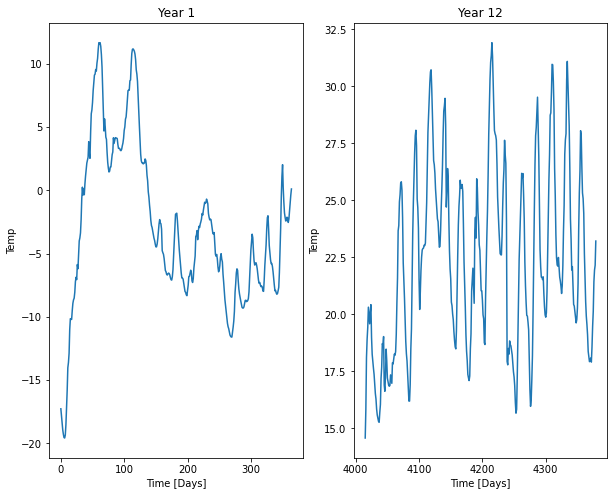

In [3]:
# Plot Year 1 and 12 without Extremes 
brf_new = np.vstack((time_ts, temp_ts)).T
fig2, ax = plt.subplots(figsize = [10, 8], ncols = 2)
ax[0].plot(brf_new[0:365, 0], brf_new[0:365, 1])
ax[0].set_ylabel("Temp")
ax[0].set_title("Year 1")
ax[1].set_title("Year 12")
ax[1].set_ylabel("Temp")
ax[0].set_xlabel("Time [Days]")
ax[1].set_xlabel("Time [Days]")
ax[1].plot(brf_new[4015:4380, 0], brf_new[4015:4380, 1])
plt.show()

In [4]:
mean = np.zeros(round(len(time_ts)/(365)))
temp_max = np.zeros([round(len(time_ts)/(365)),10])
for i, ii in zip(range(1,len(time_ts),365), range(1,round(len(time_ts)/(365))+1,1)):
    j = 365+i
    temp_sample = temp_ts[i:j]
    x = np.argsort(temp_sample)[::-1][:10]
    temp_max[ii-1] = temp_sample[x]
    mean[ii-1] = np.mean(temp_sample[x])

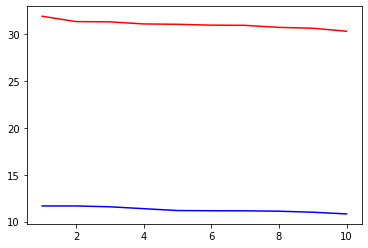

(array([11.66, 11.66, 11.57, 11.37, 11.17, 11.15, 11.14, 11.1 , 10.99,
        10.81]),
 array([31.91, 31.34, 31.31, 31.09, 31.05, 30.96, 30.94, 30.72, 30.63,
        30.31]))

In [5]:
hot_days = np.linspace(1, 10, 10)
year = (temp_max[0], temp_max[11])

plt.plot(hot_days, year[0], "b")
plt.plot(hot_days, year[1], "r")
plt
plt.show()
year

In [6]:
# Year 1 
DA = year[0];
sA = np.shape(DA);
NA = sA[0];
dobsA=eda_cvec(DA);

dtrueA = np.mean(DA);     # known size of calibrations standard'
dbarA = np.mean(DA); # known mean of measurement
sd2A=np.std(DA)**2;       # known variance of measurement
sdA=np.std(DA);        # known root-variance of measurement

print("For Year 1")

dbartrueA = dtrueA;
print("true mean %.4f" % (dbartrueA) );

dbarestA = np.sum(dobsA)/NA;
print("estimated mean %.4f" % (dbarestA) );

print("true variance %.4f" % (sd2A) );
print("true root-variance %.4f" % (sdA) );

sd2estA = np.matmul( (dobsA-dbarA).T, (dobsA-dbarA)) / (NA);
print("estimated variance (given true mean) %.4f" % sd2estA );

sdestA = sqrt(sd2estA);
print("estimated root-variance (given true mean) %.4f" % (sdestA) );

sd2estpA= np.matmul( (dobsA-dbarestA).T, (dobsA-dbarestA)) / (NA-1);
print("estimated variance (given estimated mean) %.4f" % (sd2estpA) );

sdestpA=sqrt(sd2estpA);
print("estimated root-variance (given estimated mean) %.4f" % (sdestpA));

# Year 12
DB = year[1];
sB = np.shape(DB);
NB = sB[0];
dobsB = eda_cvec(DB);

dtrueB = np.mean(DB);           # known size of calibrations standard'
dbarB = np.mean(DB);       # known mean
sd2B = np.std(DB)**2;           # known variance of measurement
sdB = np.std(DB); # known root-variance of measurement

print("For Year 2")

dbarestB = np.sum(dobsB)/NB;
print("estimated mean %.4f" % (dbarestB) );

print("true variance %.4f" % (sd2B) );
print("true root-variance %.4f" % (sdB) );

sd2estB = np.matmul( (dobsB-dbarB).T, (dobsB-dbarB)) / (NB);
print("estimated variance (given true mean) %.4f" % sd2estB );

sdestB = sqrt(sd2estB);
print("estimated root-variance (given true mean) %.4f" % (sdestB) );

sd2estpB= np.matmul( (dobsB-dbarestB).T, (dobsB-dbarestB)) / (NB-1);
print("estimated variance (given estimated mean) %.4f" % (sd2estpB) );

sdestpB=sqrt(sd2estpB);
print("estimated root-variance (given estimated mean) %.4f" % (sdestpB));

For Year 1
true mean 11.2620
estimated mean 11.2620
true variance 0.0764
true root-variance 0.2764
estimated variance (given true mean) 0.0764
estimated root-variance (given true mean) 0.2764
estimated variance (given estimated mean) 0.0849
estimated root-variance (given estimated mean) 0.2913
For Year 2
estimated mean 31.0260
true variance 0.1740
true root-variance 0.4172
estimated variance (given true mean) 0.1740
estimated root-variance (given true mean) 0.4172
estimated variance (given estimated mean) 0.1934
estimated root-variance (given estimated mean) 0.4397


In [7]:
# t-statistic 
print("difference between two means with t-test");
A = dbarA - dbarB;
B = sqrt(sd2estpA/NA+sd2estpB/NB);
t = A/B;
C = (sd2estpA/NA+sd2estpB/NB)**2;
D = ((sd2estpA/NA)**2)/(NA-1) + ((sd2estpB/NB)**2)/(NB-1);
M  =floor(C/D+0.5);
print("t is %.4f and has %d degrees of freedom" % (t, M) );

# are the means of the two tests significantly different ?
Pt = 1 - (stats.t.cdf(abs(t),M)-stats.t.cdf(-abs(t),M));
print("Probability of |t| exceeding %.4f is %.4f" % (abs(t), Pt) );
print(' ');

difference between two means with t-test
t is -118.4892 and has 16 degrees of freedom
Probability of |t| exceeding 118.4892 is 0.0000
 


#### (C) Can the Null Hypothesis be rejected?

[ANSWER] The Null Hypothesis can be rejected. 

From the plots of the temp vs time figures, we can see that the two years have very different temperatures and it makes sense that they pass the t-statistic test since there is a lot of variation that is not just from random observaton.

### 12.2. Revisit Neuse River prediction error filters that you calculated in Problem 7.2 and analyze the significance of the error reduction for pairs of filters of different length.

In [8]:
from math import exp, pi, sin, sqrt, floor, ceil
import numpy as np
import scipy.sparse.linalg as las
from scipy import sparse
import scipy.linalg as la
import scipy.signal as sg
from matplotlib import pyplot as plt

def eda_draw(*argv):
    bw = np.zeros((256,4));
    v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
    bw[:,0] = v;
    bw[:,1] = v;
    bw[:,2] = v;
    bw[:,3] = np.ones(256);
    bwcmap = ListedColormap(bw);
    # size of plot
    W = 16;
    H = 4;
    fig1 = plt.figure(1);
    # figsize width and height in inches
    fig1.set_size_inches(W,H);
    ax1 = plt.subplot(1,1,1);
    plt.axis([0, W, -H/2, H/2]);
    plt.axis('off');
    LM = W/6;    # matrix width and heoght
    LV = W/40;   # vector width
    FS = 0.12;    # character width
    TO = 0.4;    # title vertical offset
    SP = 0.2;    # space between objects
    LS = 0.2;    # leading space
    p = LS; # starting x-position
    istitle=0; # flags presence of a title
    for a in argv:
        if isinstance(a,np.ndarray):
            sh = np.shape(a);
            if len(sh) == 1:  # conversion to nx1 array
                n = sh[0];
                m = 1;
                ap = a;
                a = np.zeros((n,1));
                a[:,0] = ap;
            else:
                n = sh[0];
                m = sh[1];
            if m==1:
                pold=p;
                left=p;
                right=p+LV;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LV;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
            else:
                pold=p;
                left=p;
                right=p+LM;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LM;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
        elif isinstance(a,str):
            ns = len(a);
            istitle=0;
            if( ns>=6 ):
                if 'title ' in a[0:6]:
                    istitle=1;
                    titlestr=a[6:];
            if( istitle != 1):
                plt.text(p,0,a);
                p = p + ns*FS + SP;
    plt.show();
    return 1;

def eda_cvec1(v):
    if isinstance(v, int):
        w = np.zeros((1,1),dtype=int);
        w[0,0] = v;
        return w;
    elif isinstance(v, float):
        w = np.zeros((1,1),dtype=float);
        w[0,0] = v;
        return w;
    elif isinstance(v, complex):
        w = np.zeros((1,1),dtype=complex);
        w[0,0] = v;
        return w;
    elif isinstance(v, np.ndarray):
        s = np.shape(v);
        if len(s) == 1:
            return np.copy(np.reshape(v,(s[0],1)));
        else:
            [r,c]=s;
            if( c==1 ):
                return(np.copy(v));
            elif(r==1):
                return(np.copy(v.T));
            else:
                raise TypeError("eda_cvec: %d by %d ndarray not allowed" % (r, c));
    elif isinstance(v, list):
        r = len(v);
        t = int;
        for vi in v:
            if isinstance(vi,int):
                pass;
            elif isinstance(vi,float):
                t=float;
            elif isinstance(vi,complex):
                t=complex;
                break;
            else:
                raise TypeError("eda_cvec: list contains unsupported type %s" % type(vi));
        w = np.zeros((r,1),dtype=t);
        w[:,0] = v;
        return w;
    elif isinstance(v, tuple):
        r = len(v);
        t = int;
        for vi in v:
            if isinstance(vi,int):
                pass;
            elif isinstance(vi,float):
                t=float;
            elif isinstance(vi,complex):
                t=complex;
                break;
            else:
                raise TypeError("eda_cvec: tuple contains unsupported type %s" % type(vi));
        w = np.zeros((r,1),dtype=t);
        w[:,0] = v;
        return w;
    else:
        raise TypeError("eda_cvec: %s not supported" % type(v));
        
def eda_cvec(*argv):
    t = int;
    Nt = 0;
    for a in argv:
        v = eda_cvec1(a);
        N,M = np.shape(v);
        Nt = Nt + N;
        if( N==0 ):
            continue; # skip vector of zero length
        if (t==int) and isinstance(v[0,0],float):
            t=float;
        elif isinstance(v[0,0],complex):
            t=complex;
    w = np.zeros((Nt,1),dtype=t);
    Nt = 0;
    for a in argv:
        v = eda_cvec1(a);
        N,M = np.shape(v);
        w[Nt:Nt+N,0] = v[0:N,0];
        Nt = Nt + N;
    return w;

def FTFmul(v):
    # this function is used by the bicongugate gradient solver to solve the geneneralized least
    # squares problem Fm=f.  Note that "F" must be called "edaFsparse".
    global edaFsparse;
    s = np.shape(v);
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    temp = edaFsparse*vv;
    return edaFsparse.transpose()*temp;

def GLSFilterMul(v):
    global eda_e;
    global edaHsparse;
    global edafilterg;
    # rearrange as column-vector
    s = np.shape(v);
    M = s[0];
    if(len(s)==1): # convert to column-vector
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    N, i = np.shape(edafilterg);
    temp1 = np.zeros((N+M-1,1));
    temp1[:,0] = np.convolve(edafilterg.ravel(),vv.ravel());
    a = np.zeros((N,1));
    a[:,0] = temp1[0:N,0];
    b = eda_e*edaHsparse * v; 
    temp2 = np.zeros((N+N-1,1));
    temp2[:,0] = np.convolve(
        (np.flipud(edafilterg)).ravel(),a.ravel());
    a2 = temp2[N-1:N+M-1,0];
    b2 = eda_e*edaHsparse.transpose()*b;
    # a2+b2 = FT F v = GT G v + (e^**2) HT H v
    return (a2+b2);

def GLSFilterMulRHS(g,dobs,e,H,h,M):
    # companion function to GLSFilterMul()
    # creates RHS of generalized least squares equattion
    # set up right hand side, F'f = GT qobs + e HT h
    # note that H must be sparse
    N,i = np.shape(dobs);
    temp = eda_cvec( np.convolve(np.flipud(g).ravel(),dobs.ravel()) );
    FTfa = eda_cvec( temp[N-1:N+M-1,0] );
    FTfb = (e**2)*H.T*h;
    FTf=FTfa+FTfb;
    return (FTf);

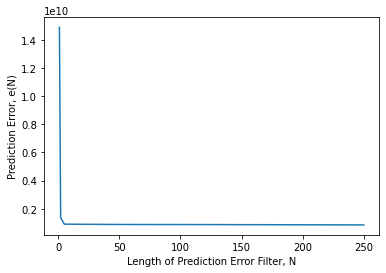

In [9]:
# Read-in Data
neuse = np.genfromtxt('../Data/neuse.txt', delimiter='\t')
[X, Y] = neuse.shape; # L is the length of the Dataset
t = np.array(neuse[:,0]);
d = np.array(neuse[:,1]);
Dt = t[1]-t[0];
# Create Array for each Length N, of the prediction error filter. 
N = [1, 2, 5, 7, 10, 25, 50, 75, 100, 250]
N_len = len(N)
def PEF(N):
    K = 1 # one piece of prior information
    L = X + K # total number of equations
    g = d; # for a prediction error filter, pef, the data is the filter, g 
    edafilterg = d;
    # Set up the first value 
    eda_e=(10^1)*np.amax(g); # large weight
    H=np.zeros((K,N));  # the pror information equation, Hm=h, such that m(1)=(-1);
    H[0,0]=1.0;            
    h=eda_cvec( (-1.0) );
    # Data Kernel
    Gcol = g;
    Grow = eda_cvec( g[0], np.zeros((N-1,1)));
    G = la.toeplitz( Gcol, Grow.T ); # Toeplitz matrix version of impulse response
    F = np.concatenate( (G, eda_e*H), axis=0 ); # F needed only for standard matrix algebra calculation
    rhs = np.zeros((X,1));
    f = np.concatenate( (rhs, eda_e*h), axis=0 );
    # standard GLS solution
    FTF = np.matmul( F.T, F );  
    FTf = np.matmul( F.T, f ); 
    pef = la.solve(FTF, FTf ); # least squares solution
    # Prediction Error
    temp = np.convolve(pef.ravel(),g.ravel());
    perror = eda_cvec( temp[0:X] );
    perror_all = np.matmul(perror.T,perror);
    return perror_all

pef_out = []
for i in range(N_len):
    pef_out.append(PEF(N[i]))
pef_arr = np.array(pef_out) 
pef_x = np.array(pef_arr[:,0]);

#Plot Prediction Error as function of PEF Length
plt.plot(N, pef_x)
plt.ylabel('Prediction Error, e(N)')
plt.xlabel('Length of Prediction Error Filter, N')

#plt.title('Prediction error, e, as a function of the length, N, of the prediction error filter')
plt.show()

In [10]:
# For 1 and 2
EA = pef_x[0]
EB = pef_x[1]
vA = N_len - 1
vB = N_len - 2
print("improvement in error %.2f" % ((EA-EB)/EA) );
F = (EA/vA) / (EB/vB);
print("1/F %.4f F %.4f" % (1/F,F) );
if( F<1 ):
    F=1/F
P = 1 - (stats.f.cdf(F,vA,vB)-stats.f.cdf(1/F,vA,vB));
print("P(F<%.4f or F>%.4f) = %f" % (1/F, F, P) );

if( P>0.05):
    print('Null hypothesis cannot be excluded to 95% confidence')
else:
    print('Null hypothesis can be excluded to 95% confidence')

improvement in error 0.91
1/F 0.1042 F 9.6014
P(F<0.1042 or F>9.6014) = 0.003368
Null hypothesis can be excluded to 95% confidence


In [11]:
# For 7 and 8
EA = pef_x[6]
EB = pef_x[7]
vA = N_len - 1
vB = N_len - 2
print("improvement in error %.2f" % ((EA-EB)/EA) );
F = (EA/vA) / (EB/vB);
print("1/F %.4f F %.4f" % (1/F,F) );
if( F<1 ):
    F=1/F
P = 1 - (stats.f.cdf(F,vA,vB)-stats.f.cdf(1/F,vA,vB));
print("P(F<%.4f or F>%.4f) = %f" % (1/F, F, P) );

if( P>0.05):
    print('Null hypothesis cannot be excluded to 95% confidence')
else:
    print('Null hypothesis can be excluded to 95% confidence')

improvement in error 0.00
1/F 1.1209 F 0.8921
P(F<0.8921 or F>1.1209) = 0.871912
Null hypothesis cannot be excluded to 95% confidence


### 12.4. Fig.12.6 B shows the power spectral density of a random time series. 

#### A) Count up the number of peaks that are significant to the 95% level or greater and compare with the expected number. 

[ANSWER] Actual 16 Peaks, Expected = 10 peak

#### B) What is the significance level of the highest peak? (Note that N = 1024 and c = 0.634 for this dataset).

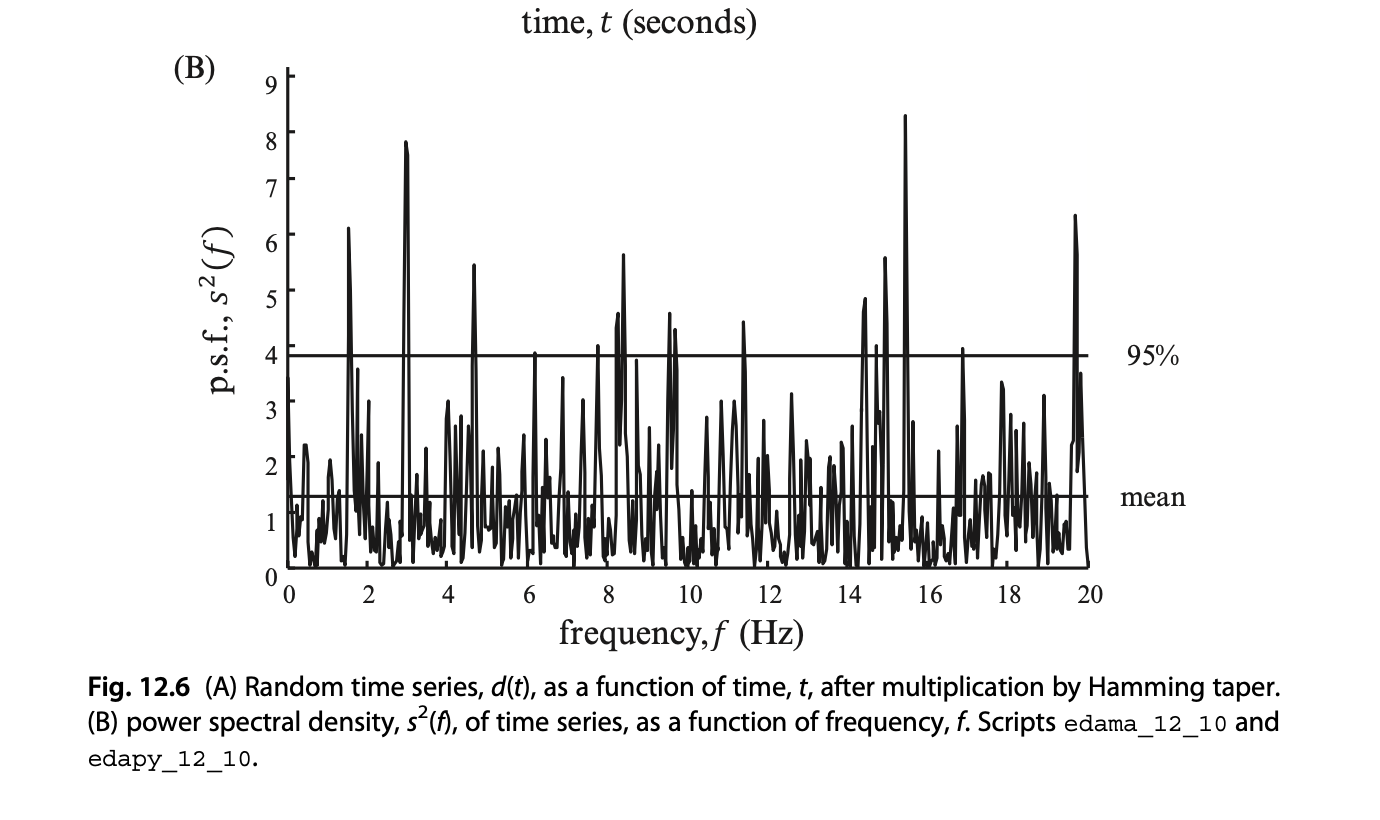

true      data variance 25.4092
estimated data variance 23.8485
variance of data estimated from PSD 23.87
 
power spectral density
true mean 1.2680 variance 1.6078
estimated mean 1.1910 variance 1.7056
 


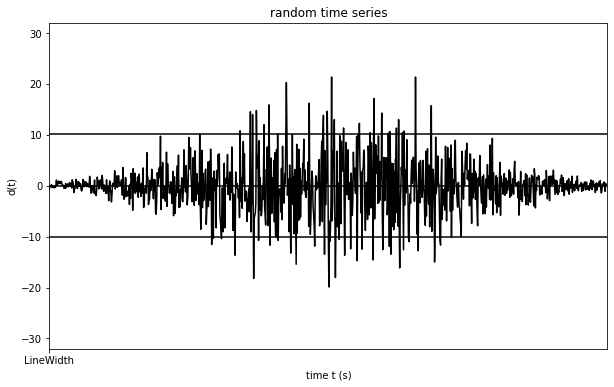

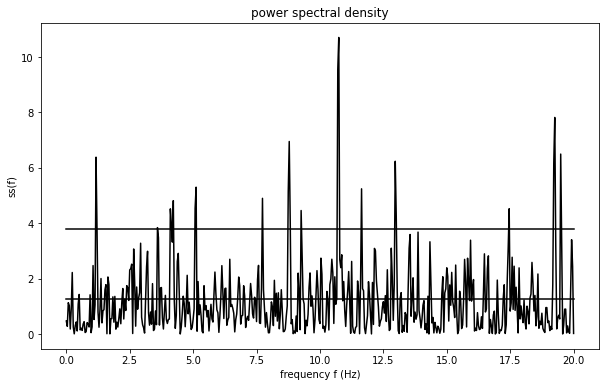

0.9500 confidence level is at s2 = 3.7985
95.7115 percent of points are below 0.9500 confidence
 


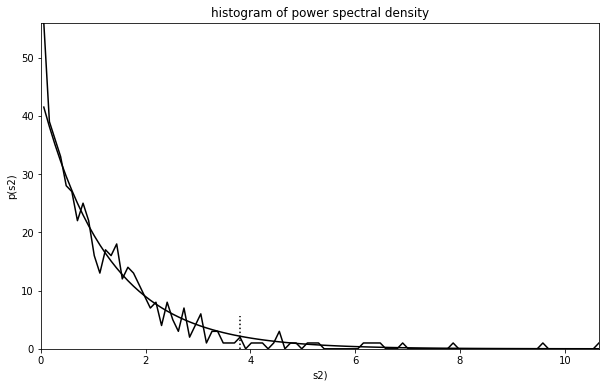

largest spectral peak: 1.070635e+01
probability of laregst peak 0.99978473
probability of PSD exceeding maximum observed value 0.00021527
Nf probability of PSD exceeding maximum observed value 0.10456465


In [12]:
# edapy_12_10: variance of power spectral density (tapered)
# case of random timeseries tapered with Hamming window

# generic time set up
N=floor(2**10);  # number of points in time series
Dt=0.025;        # sampling interval
T = N*Dt;        # duration
t = eda_cvec(Dt*np.linspace(0,N-1,N)); # time vector

# create an uncorrelated random timeseries
sd2true=64.0;          # variance
sdtrue=sqrt(sd2true);  # std dev
draw = np.random.normal(0,sdtrue,(N,1)); # time series of random data

# generic frequency set up
No2 = floor(N/2);   # integer version of N.2
fmax=1/(2.0*Dt);    # nyquist frequency
Df=fmax/No2;        # frequency sampling
Nf=No2+1;           # number of non-negative frequencies
# full (pos and neg) frequency vector
f=eda_cvec(Df*np.concatenate((np.linspace(0,No2,Nf),np.linspace(-No2+1,-1,No2-1)),axis=0));
Dw=2.0*pi*Df;       # angular feqweuncy sampling
w=2.0*pi*f;         # full (pos and neg) angular fedquency vector
Nw=Nf;              # number of non-negative angular frequencies
fpos=eda_cvec(Df * np.linspace(0,No2,Nf)); # vector of non-negative frequencies
wpos=2.0*pi*fpos;   # vector of non-negative angular frequencies                              

#  Hamming window function
W = eda_cvec( 0.54 - 0.46*np.cos(2*pi*np.linspace(0,N-1,N)/(N-1)) );
d = np.multiply( W, draw );
# window changes variance of signal by ff

ff = np.sum(np.multiply(W,W))/N;

# true and estimated variance of d
sd2est=np.std(d)**2;
print("true      data variance %.4f" % (ff*sd2true) );
print("estimated data variance %.4f" % (sd2est));

# compute power spectral density
fftraw = np.zeros((N,1), dtype=complex);
fftraw = np.fft.fft(d,axis=0);                # Fourier transform
dbar = eda_cvec(Dt*fftraw[0:Nf,0]);           # keep non-negative frequencies, only
s2 = (2/T) * np.power(np.abs(dbar),2);        # power spectral density

# statistics of power spectral density
s2meanest = np.mean(s2);                      # mean
s2varest=np.std(s2)**2;                       # vaiance
s2sigmaest=sqrt(s2varest);                    # standard deviation
sd2psd=Nf*Df*s2meanest;                       # variance of data estimated from PSD
print("variance of data estimated from PSD %.2f" % (sd2psd));
print(' ');

# true mean and variance
p=2; # degrees of freedom
c = ( ff*sd2true ) / (2*Nf*Df);  # normalization factor
s2meantrue = p*c;                # mean of chi-squaed p.d.f., with normalization
s2vartrue = 2*p*(c**2);          # variance of chi-squaed p.d.f., with normalization
print("power spectral density");
print("true mean %.4f variance %.4f" % (s2meantrue,s2vartrue));
print("estimated mean %.4f variance %.4f" % (s2meanest,s2varest));
print(' ');

# plot data
fig1 = plt.figure(1,figsize=(10,6));
damax = np.amax(d);
plt.axis([0, T, -1.5*damax, 1.5*damax])
plt.plot(t,d,'k-');
plt.xlabel('time t (s)');
plt.ylabel('d(t)');
plt.title('random time series');
plt.plot([0, T], [-2*sdtrue*sqrt(ff), -2*sdtrue*sqrt(ff)], 'k-' );
plt.plot([0, T], [0, 0], 'k-', 'LineWidth', 1 );
plt.plot([0, T], [2*sdtrue*sqrt(ff), 2*sdtrue*sqrt(ff)], 'k-' );

# plot p.s.d.
fig2 = plt.figure(2,figsize=(10,6));
plt.xlabel('frequency f (Hz)');
plt.ylabel('ss(f)');
plt.title('power spectral density');
plt.plot(fpos,s2,'k-');

# plot mean on spectra
plt.plot([0, fmax], [s2meantrue, s2meantrue],'k-');

# histogram of values
Nhist=100               # number of bins in histogram
s2min = np.min(s2);     # start bin
s2max = np.max(s2);     # end bin
ct, ed = np.histogram(s2,Nhist,(s2min,s2max)); # histogram
Nc = len(ct);           # number of counts ct
Ne = len(ed);           # number of edges ed
s2hist = eda_cvec(ct);  # counts as a vector
centers = eda_cvec(0.5*(ed[1:Ne]+ed[0:Ne-1])); # edges as a vector

# chi-squared pdf
Db=(centers[1,0]-centers[0,0])/c;               # normalization factor
s2histtrue=Nf*Db*stats.chi2.pdf(centers/c,p);   # true hisogram from chi-squared p.d.f.

# plot 95% confidence level on spectra
pv=0.95;
cv = stats.chi2.ppf(pv,p);
plt.plot([fpos[0,0], fpos[Nf-1,0]], [cv*c, cv*c],'k-');
plt.show();
print("%.4f confidence level is at s2 = %.4f" % (pv,cv*c) );
percent = 100 * np.sum( s2hist[centers<=cv*c]) / np.sum(s2hist);
print("%.4f percent of points are below %.4f confidence" % (percent,pv));
print(' ');

fig3 = plt.figure(3,figsize=(10,6));
plt.axis([0, np.max(centers), 0, np.max(s2hist) ])
plt.xlabel('s2)');
plt.ylabel('p(s2)');
plt.title('histogram of power spectral density');
plt.plot(centers,s2hist,'k-');
plt.plot(centers,s2histtrue,'k-');
plt.plot([cv*c, cv*c], [0, 0.1*np.max(s2hist)],'k:');
plt.show();
# probability that PSD exceeds maximum observed value
speak = np.max(s2);
print("largest spectral peak: %e" % (speak) );
ppeak = stats.chi2.cdf(speak/c,p);
print("probability of laregst peak %.8f" % (ppeak) );
print("probability of PSD exceeding maximum observed value %.8f" % (1-ppeak) );
print("Nf probability of PSD exceeding maximum observed value %.8f" % (1-(ppeak**Nf)) );


[ANSWER] In this example, the power spectral density has N/2 + 1 = 513 elements. Thus, there are 513 independent chances for a peak to occur. The probability that a peak of amplitude, s20, occurs somewhere among those 513 possibilities is (0.99994)513 = 0.97. Thus, there is a 3% chance that a peak arose from random variation still a small probability, but much larger than the 0.006% that we calculated previously We can still reject the Null Hypothesis at greater than 95% confidence, but with much less confidence than before.

### 12.5. Determine the significance of the annual peak in the power spectral density of the Neuse River Hydrograph (see Fig. 6.11 and scripts edama_06_13 and edapy_06_13).

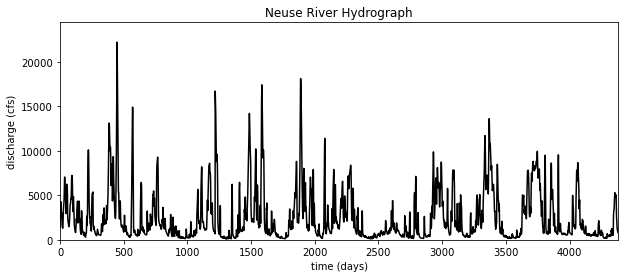

/var/folders/rb/hdqt_y791p1_9slxr5vqnj0c0000gn/T/ipykernel_20012/2112573679.py:76: RuntimeWarning: invalid value encountered in reciprocal
  plt.plot(np.reciprocal(fpos[1:Nf,0]), s2[1:Nf,0],'k-');


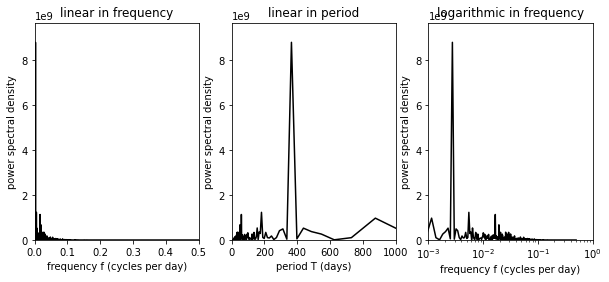

variance estimated from time series            8.396180e+06
variance estimated from power spectral density 8.396180e+06


In [13]:
# edapy_06_15: p.s.d. of the Neuse River hydrograph
# properly normalized amplitude spectral density of
# Neuse River hydrograph using FFT

# load data from file
D = np.genfromtxt('../Data/neuse.txt', delimiter='\t')
[Nraw, K]=D.shape;
traw = eda_cvec( D[:,0] ); # time
Dt = traw[1,0]-traw[0,0];  # sampling interval
draw = eda_cvec( D[:,1] ); # data

# round off to even number of points
No2 = floor(Nraw/2);
N=2*No2;
d = eda_cvec( draw[0:N,0] );
t = eda_cvec( traw[0:N,0] );

# generic time set up
tmin = 0;
tmax = Dt*(N-1);
t=eda_cvec(np.linspace(tmin,tmax,N));

# generic frequency set up
No2 = floor(N/2);  # integer version of N/2
M=N;               # number of model parameters equal number of data
fmax=1/(2.0*Dt);   # nyquist frequency
Df=fmax/No2;       # frequency sampling
Nf=No2+1;          # number of non-negative frequenices
# full (pos, neg) frequency vector
f=eda_cvec(Df * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 ));
Dw=2*pi*Df;        # angular frequency sampling
w=2*pi*f;          # full (pos, neg) anguar frequency vector
Nw=Nf;             # number of non-negative angular frequencies
fpos=eda_cvec(Df * np.linspace(0,No2,Nf)); # non-negative frequencies
wpos=2*pi*fpos;    # non-negative angular frequencies

#  compute fourier coefficients. Note normalization of Dt
dbar = Dt*np.fft.fft(d, axis=0); # fourier transform
dbarpos = dbar[0:Nf,0:1]; # non-negative frequencies
T = N*Dt;  # time series length
# p.s.d.
s2 = (2/T) * np.real(np.multiply(dbarpos.conj(), dbarpos));

# plot data
fig1 = plt.figure(1,figsize=(10,4));
plt.rcParams['xtick.bottom'] = True;
plt.rcParams['xtick.labelbottom'] = True;
plt.rcParams['xtick.top'] = False;
plt.rcParams['xtick.labeltop'] = False;

ax1 = plt.subplot(1,1,1);
plt.axis([np.min(t), np.max(t), 0, 1.1*np.max(d) ]);
plt.plot(t,d,'k-');
plt.xlabel('time (days)');
plt.ylabel('discharge (cfs)');
plt.title('Neuse River Hydrograph');
plt.show();

# plot power spectral density
fig2 = plt.figure(2,figsize=(10,4));
plt.rcParams['xtick.bottom'] = True;
plt.rcParams['xtick.labelbottom'] = True;
plt.rcParams['xtick.top'] = False;
plt.rcParams['xtick.labeltop'] = False;

ax1 = plt.subplot(1,3,1);
plt.axis([0, fmax, 0, 1.1*np.max(s2[1:Nf,0]) ]);
plt.plot(fpos[1:Nf,0],s2[1:Nf,0],'k-');
plt.xlabel('frequency f (cycles per day)');
plt.ylabel('power spectral density');
plt.title('linear in frequency');

ax1 = plt.subplot(1,3,2);
Tmax = 1000;
plt.axis([0, Tmax, 0, 1.1*np.max(s2[1:Nf,0]) ]);
plt.plot(np.reciprocal(fpos[1:Nf,0]), s2[1:Nf,0],'k-');
plt.xlabel('period T (days)');
plt.ylabel('power spectral density');
plt.title('linear in period');

ax1 = plt.subplot(1,3,3);
plt.axis([0.001, 1, 0, 1.1*np.max(s2[1:Nf,0])]);
plt.semilogx(fpos[1:Nf,0], s2[1:Nf,0], 'k-', base=10);
plt.xlabel('frequency f (cycles per day)');
plt.ylabel('power spectral density');
plt.title('logarithmic in frequency');

plt.show();

# variance calculation
v1 = np.std(d)**2;
printstr = "variance estimated from time series            %.6e" % (v1);
print(printstr);
v2 = Df * np.sum(s2[1:Nf,0]);
printstr = "variance estimated from power spectral density %.6e" % (v2);
print(printstr);


true      data variance 3335892.7222
estimated data variance 8396179.9247
variance of data estimated from PSD 21175923.10
 
power spectral density
true mean 6668741.7466 variance 44472116483271.1094
estimated mean 42332525.0933 variance 1469231713606076928.0000
 


/var/folders/rb/hdqt_y791p1_9slxr5vqnj0c0000gn/T/ipykernel_20012/2636991951.py:50: RuntimeWarning: invalid value encountered in reciprocal
  plt.plot(np.reciprocal(fpos[1:Nf,0]), s2[1:Nf,0],'k-');


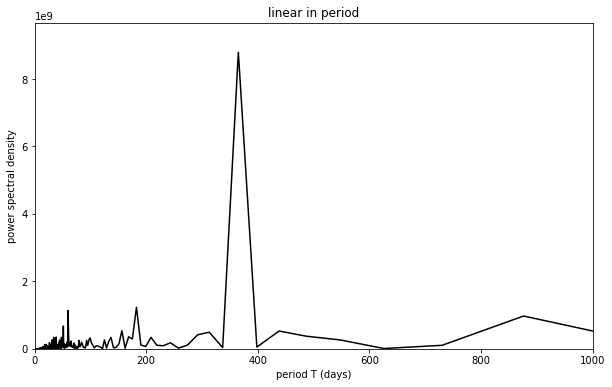

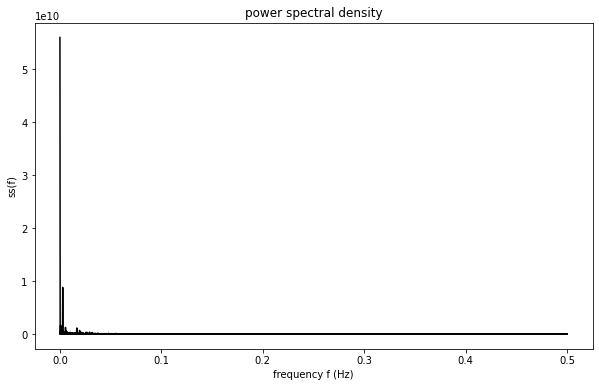

0.9500 confidence level is at s2 = 19977764.8744
0.0000 percent of points are below 0.9500 confidence
 


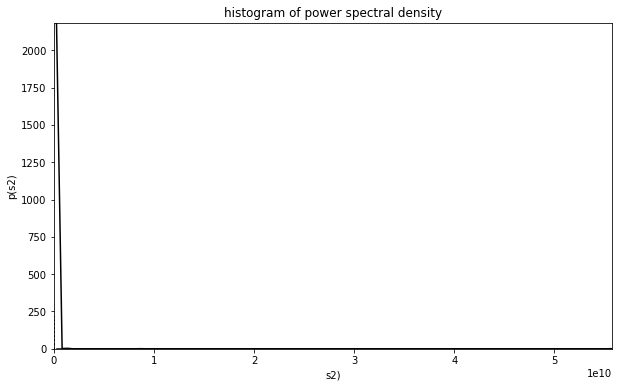

largest spectral peak: 5.600083e+10
probability of largest peak 1.00000000
probability of PSD exceeding maximum observed value 0.00000000
Nf probability of PSD exceeding maximum observed value 0.00000000


In [14]:
# edapy_12_11, confidence of spectral peak
# for random noise plus a small ampliude sinusoid

# low amplitude periodic signal buried in the noise
sd2true= v1;          # variance
sdtrue=sqrt(sd2true);  # standard deviation
# data = signal + noise
draw = 0.25*sdtrue*np.cos(2*pi*(fmax/4)*t) + np.random.normal(0,sdtrue,(N,1));                

#  Hamming window function
W = eda_cvec(0.54 - 0.46*np.cos(2*pi*np.linspace(0,N-1,N)/(N-1)));
#d = np.multiply( W, draw );

# window changes variance of signal by ff
ff = np.sum(np.multiply(W,W))/N;

# true and estimated variance of d
sd2est=np.std(d)**2;
print("true      data variance %.4f" % (ff*sd2true) );
print("estimated data variance %.4f" % (sd2est));

# compute power spectral density
fftraw = np.fft.fft(d,axis=0);         # Fourier transform
dbar = eda_cvec(Dt*fftraw[0:Nf,0]);    # keep non-negative frequencies, only
#s2 = (2/T) * np.power(np.abs(dbar),2); # power spectral density

# statistics of power spectral density
s2meanest = np.mean(s2);     # mean
s2varest=np.std(s2)**2;      # variance
s2sigmaest=sqrt(s2varest);   # standard deviation
sd2psd=Nf*Df*s2meanest;      # variance of data estimated from PSD
print("variance of data estimated from PSD %.2f" % (sd2psd));
print(' ');

# true mean and variance
p=2; # degrees of freedom
c = ( ff*sd2true ) / (2*Nf*Df);  # normalization factor
s2meantrue = p*c;                # true mean of normalizenchi-suqared distribution
s2vartrue = 2*p*(c**2);          # true varoance of normalized chi-suqared distribution
print("power spectral density");
print("true mean %.4f variance %.4f" % (s2meantrue,s2vartrue));
print("estimated mean %.4f variance %.4f" % (s2meanest,s2varest));
print(' ');

# plot PSD

Tmax = 1000;
fig1 = plt.figure(1,figsize=(10,6));
plt.axis([0, Tmax, 0, 1.1*np.max(s2[1:Nf,0]) ]);
plt.plot(np.reciprocal(fpos[1:Nf,0]), s2[1:Nf,0],'k-');
plt.xlabel('period T (days)');
plt.ylabel('power spectral density');
plt.title('linear in period');

fig2 = plt.figure(2,figsize=(10,6));
plt.xlabel('frequency f (Hz)');
plt.ylabel('ss(f)');
plt.title('power spectral density');
plt.plot(fpos, s2,'k-');

# plot mean on spectra
plt.plot([0, fmax], [s2meantrue, s2meantrue],'k-');

# histogram of values
Nhist=100;            # number of bins in histogram
s2min = np.min(s2);   # start bin
s2max = np.max(s2);   # end bin
ct, ed = np.histogram(s2,Nhist,(s2min,s2max)); # histogram
Nc = len(ct);         # number of counts ct
Ne = len(ed);         # number of edges ed
s2hist = eda_cvec(ct);                         # counts as a vector
centers = eda_cvec(0.5*(ed[1:Ne]+ed[0:Ne-1])); # bin centers as a vector

# chi-squared pdf
Db=(centers[1,0]-centers[0,0])/c;
# true histogram derived from normalized chi-squared distribution
s2histtrue=Nf*Db*stats.chi2.pdf(centers/c,p);  

# plot 95% confidence level on spectra
pv=0.95;
cv = stats.chi2.ppf(pv,p);
plt.plot([fpos[0,0], fpos[Nf-1,0]], [cv*c, cv*c],'k-');
plt.show();
print("%.4f confidence level is at s2 = %.4f" % (pv,cv*c) );
percent = 100 * np.sum( s2hist[centers<=cv*c]) / np.sum(s2hist);
print("%.4f percent of points are below %.4f confidence" % (percent,pv));
print(' ');

fig3 = plt.figure(3,figsize=(10,6));
plt.axis([0, np.max(centers), 0, np.max(s2hist) ])
plt.xlabel('s2)');
plt.ylabel('p(s2)');
plt.title('histogram of power spectral density');
plt.plot(centers,s2hist,'k-');
plt.plot(centers,s2histtrue,'k-');
plt.plot([s2meantrue, s2meantrue], [0, 0.1*np.max(s2hist)],'k:');
plt.plot([cv*c, cv*c], [0, 0.1*np.max(s2hist)],'k:');
plt.show();

# probability that PSD exceeds maximum observed value
speak = np.max(s2);
print("largest spectral peak: %e" % (speak) );
ppeak = stats.chi2.cdf(speak/c,p);
print("probability of largest peak %.8f" % (ppeak) );
print("probability of PSD exceeding maximum observed value %.8f" % (1-ppeak) );
print("Nf probability of PSD exceeding maximum observed value %.8f" % (1-(ppeak**Nf)) );

[ANSWER] From the figure above, we can see that the highest peak for the Neuse dataset is the annual peak at around 365ish from the first figure. 